In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

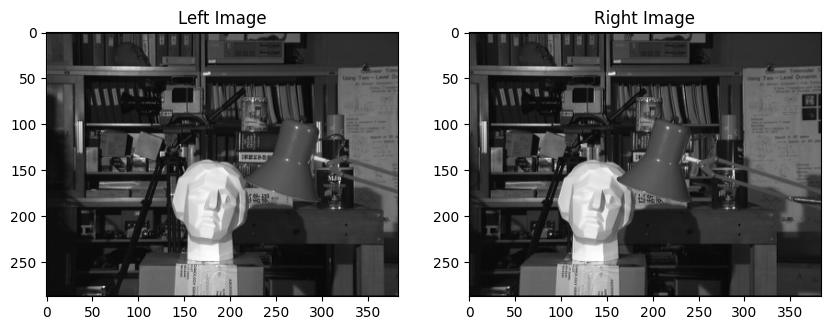

In [20]:
tsukuba_left = cv2.imread('tsukuba_left.png')
tsukuba_right = cv2.imread('tsukuba_right.png')

gray_tsukuba_left = cv2.cvtColor(tsukuba_left, cv2.COLOR_RGB2GRAY)
gray_tsukuba_right = cv2.cvtColor(tsukuba_right, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_tsukuba_left, cmap='gray')
plt.title('Left Image')
plt.subplot(1,2,2)
plt.imshow(gray_tsukuba_right, cmap='gray')
plt.title('Right Image')
plt.show()

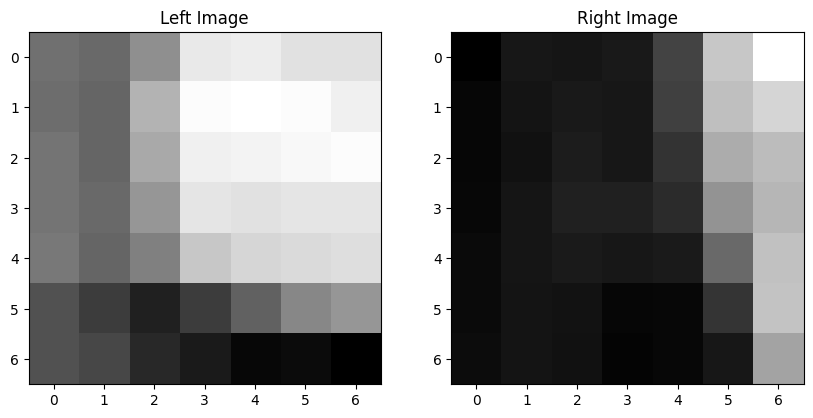

In [21]:
nose_left = cv2.imread('nose_left.png')
nose_right = cv2.imread('nose_right.png')

gray_nose_left = cv2.cvtColor(nose_left, cv2.COLOR_RGB2GRAY)
gray_nose_right = cv2.cvtColor(nose_right, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_nose_left, cmap='gray')
plt.title('Left Image')
plt.subplot(1,2,2)
plt.imshow(gray_nose_right, cmap='gray')
plt.title('Right Image')
plt.show()

In [22]:
def compute_sad(imageA, imageB):
    return np.sum(np.abs(imageA.astype(np.int32) - imageB.astype(np.int32)))

def compute_ssd(imageA, imageB):
    return np.sum((imageA.astype(np.int32) - imageB.astype(np.int32))**2)

SAD = compute_sad(gray_nose_left, gray_nose_right)
SSD = compute_ssd(gray_nose_left, gray_nose_right)
print(f'Sum of Absolute Differences (SAD) between nose left and right images: {SAD}')
print(f'Sum of Squared Differences (SSD) between nose left and right images: {SSD}')

Sum of Absolute Differences (SAD) between nose left and right images: 7657
Sum of Squared Differences (SSD) between nose left and right images: 1274699


In [23]:
nose_images = ["nose_left.png", "nose_right.png", "nose1.png", "nose2.png", "nose3.png"]
gray_images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2GRAY) for img in nose_images]

sad_list_compared_to_nose_left = [compute_sad(gray_images[0], img) for img in gray_images[1:]]
smallest_sad_index = np.argmin(sad_list_compared_to_nose_left) + 1
print(f'The image most similar to nose_left is: {nose_images[smallest_sad_index]} with SAD value: {sad_list_compared_to_nose_left[smallest_sad_index - 1]}')

The image most similar to nose_left is: nose2.png with SAD value: 119


Best match for nose_left in nose_span starts at column: 132


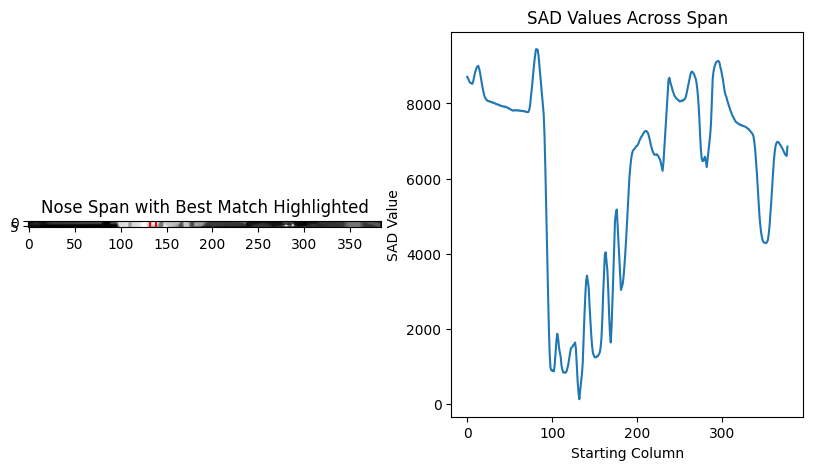

In [24]:
def find_best_match_along_row(span, template, zero_mean: bool = False):

    Hs, Ws = span.shape
    Ht, Wt = template.shape
    assert Hs == Ht, f"Row heights must match. span={Hs}, template={Ht}"

    max_x = Ws - Wt
    if max_x < 0:
        raise ValueError("Template wider than span. Check your inputs.")

    # optional normalization once for template
    if zero_mean:
        tpl = template.astype(np.int32) - int(template.mean())
    else:
        tpl = template

    sad_values = np.empty(max_x + 1, dtype=np.int64)

    for x in range(max_x + 1):
        win = span[:, x:x+Wt]
        if zero_mean:
            win_proc = win.astype(np.int32) - int(win.mean())
            sad_values[x] = np.abs(win_proc - tpl).sum()
        else:
            sad_values[x] = compute_sad(win, tpl)

    best_x = int(np.argmin(sad_values))
    return best_x, sad_values

nose_span = cv2.imread('nose_span.png')
gray_nose_span = cv2.cvtColor(nose_span, cv2.COLOR_RGB2GRAY)
best_x, sad_values = find_best_match_along_row(gray_nose_span, gray_nose_left, zero_mean=False)
print(f'Best match for nose_left in nose_span starts at column: {best_x}')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_nose_span, cmap='gray')
plt.axvline(x=best_x, color='r', linestyle='--')
plt.axvline(x=best_x + gray_nose_left.shape[1], color='r', linestyle='--')
plt.title('Nose Span with Best Match Highlighted')
plt.subplot(1,2,2)
plt.plot(sad_values)
plt.title('SAD Values Across Span')
plt.xlabel('Starting Column')
plt.ylabel('SAD Value')
plt.show()


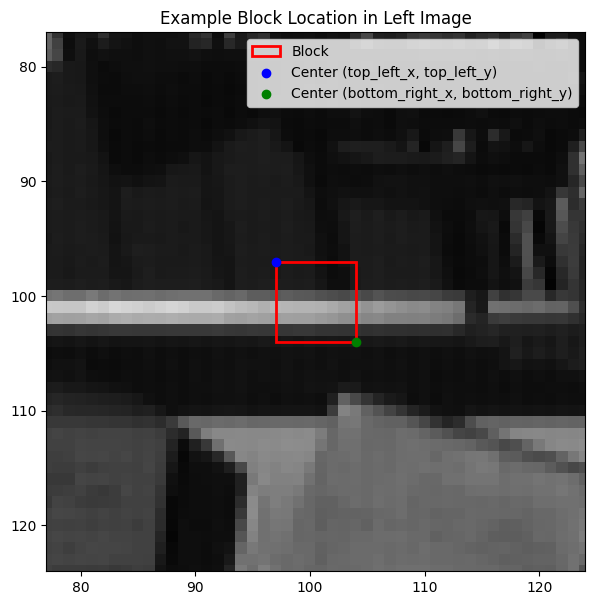

In [ ]:
# Example values for a 7x7 window at (x, y) = (100, 50)
win = 7
r = win // 2
x, y = 100, 100

top_left_x = x - r
top_left_y = y - r
bottom_right_x = x + r + 1
bottom_right_y = y + r + 1

plt.figure(figsize=(7, 7))
plt.imshow(gray_tsukuba_left, cmap='gray', origin='upper') # notice that the origin 
rect = plt.Rectangle((top_left_x, top_left_y), win, win, edgecolor='red', facecolor='none', linewidth=2, label='Block')
plt.gca().add_patch(rect)
plt.scatter([top_left_x], [top_left_y], color='blue', label='Center (top_left_x, top_left_y)')
plt.scatter([bottom_right_x], [bottom_right_y], color='green', label='Center (bottom_right_x, bottom_right_y)')
plt.title('Example Block Location in Left Image')
plt.legend()
plt.xlim(top_left_x - 20, bottom_right_x + 20)
plt.ylim(bottom_right_y + 20, top_left_y - 20)  # invert y-axis for image
plt.show()

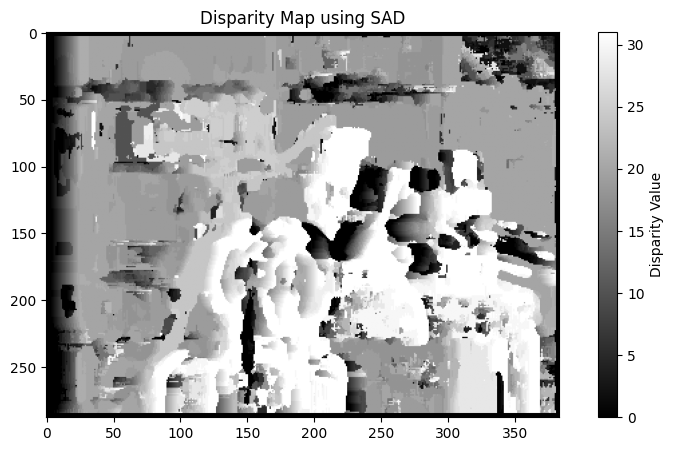

In [ ]:
def stereo_block_match_sad(left_image, right_image, win=7, max_disparity=32):
    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    H, W = left_image.shape

    window_radius = win // 2
    disparity = np.zeros((H, W), dtype=np.uint8)
    valid_start = window_radius
    valid_end_y = H - window_radius
    valid_end_x = W - window_radius

    for y in range(valid_start, valid_end_y):
        for x in range(valid_start, valid_end_x):
            best_offset = 0
            min_sad = float('inf')
            top_left_x = x - window_radius
            top_left_y = y - window_radius
            bottom_right_x = x + window_radius + 1
            bottom_right_y = y + window_radius + 1
            left_block = left_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            for offset in range(max_disparity):
                if x - window_radius - offset < 0:
                    continue
                right_block = right_image[top_left_y:bottom_right_y, top_left_x - offset:bottom_right_x - offset]
                sad = compute_sad(left_block, right_block)
                if sad < min_sad:
                    min_sad = sad
                    best_offset = offset
            disparity[y, x] = best_offset

    return disparity

disparity_map = stereo_block_match_sad(tsukuba_left, tsukuba_right, win=7, max_disparity=32)
plt.figure(figsize=(10,5))
plt.imshow(disparity_map, cmap='gray')
plt.title('Disparity Map using SAD')
plt.colorbar(label='Disparity Value')
plt.show()
